# Sentinel-1 

We want to use Sentinel-1 radar images to detect barges and ships when there is cloud coverage on the Planet Labs satellite imagery.

In [1]:
from sentinelhub import SHConfig
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, DataCollection

# You must set instance_id, sh_client_id, and sh_client_secret in a local config file (see documentation)

config = SHConfig()
config

SHConfig(
  instance_id='aa86d4ad-9b9d-4154-9a1b-b119e6f68d69',
  sh_client_id='36bcd302-fd3b-4488-941a-54441bb8db18',
  sh_client_secret='el2)!^a,aUrjX-}1U/m.4|M;pw.3+frg93&02Q*Q',
  sh_base_url='https://services.sentinel-hub.com',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5,
  download_timeout_seconds=120,
  number_of_download_processes=1
)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

def plot_image(image, save_dir=None, factor=1.0, clip_range = None, show=True, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

    if save_dir:
        fig.savefig(save_dir)

    if not show:
        plt.close()

dir_path = os.getcwd()

In [4]:
print('Supported DataCollections:\n')
for collection in DataCollection.get_available_collections():
    print(collection)

DataCollection.SENTINEL1

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT8
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR


<DataCollection.SENTINEL1: DataCollectionDefinition(
  api_id: S1GRD
  catalog_id: sentinel-1-grd
  wfs_id: DSS3
  collection_type: Sentinel-1
  sensor_type: C-SAR
  processing_level: GRD
  orbit_direction: BOTH
  is_timeless: False
  has_cloud_coverage: False
)>

## Barge locations from drone images, 3/25-3/28
This is where the barges are (see https://docs.google.com/spreadsheets/d/1GtfuzJnN7G5481bDDwzcZca5_KApqE64pKJxWUwG9wA/edit?usp=sharing):
* 9.620842°
* 64.94333°


* 9.618517
* 64.942


* 9.516611°
* 64.81439°


* 9.517417°
* 64.81469°

## Get satellite tile images from Sentinel 1, masked with geojson

x -64.81439
y -9.516611
bbox -64.82439000000001,-9.526610999999999,-64.80439,-9.506611
time_interval_path /Users/maggiewang/Dropbox/School/Harvard/senior_spring/cs288/amazon-barge-detection/data-collection/../data/2021-02-19_2021-02-24
image_path /Users/maggiewang/Dropbox/School/Harvard/senior_spring/cs288/amazon-barge-detection/data-collection/../data/2021-02-19_2021-02-24/longlat-64.81439_-9.516611.tiff
image [[[ 48   9  27 255]
  [ 48   9  27 255]
  [ 48   9  27 255]
  ...
  [  1   4   1 255]
  [  1   4   1 255]
  [  0   3   0 255]]

 [[ 16  11   8 255]
  [ 48   9  27 255]
  [ 49  11  23 255]
  ...
  [ 12   6  10 255]
  [ 12   6  10 255]
  [  6   6   5 255]]

 [[ 16  11   8 255]
  [ 16  11   8 255]
  [ 26  11  12 255]
  ...
  [ 12   6  10 255]
  [  6   6   5 255]
  [  6   6   5 255]]

 ...

 [[ 10   1  38 255]
  [ 14   1  61 255]
  [ 14   1  61 255]
  ...
  [ 96  54   9 255]
  [ 96  54   9 255]
  [ 96  54   9 255]]

 [[ 10   1  38 255]
  [ 14   1  61 255]
  [ 14   1  61 255]
  ...
 

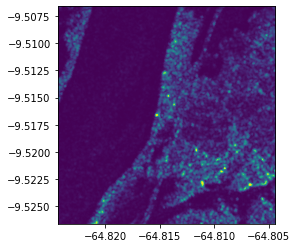

x -64.81439
y -9.516611
bbox -64.82439000000001,-9.526610999999999,-64.80439,-9.506611
time_interval_path /Users/maggiewang/Dropbox/School/Harvard/senior_spring/cs288/amazon-barge-detection/data-collection/../data/2021-03-25_2021-03-27
image_path /Users/maggiewang/Dropbox/School/Harvard/senior_spring/cs288/amazon-barge-detection/data-collection/../data/2021-03-25_2021-03-27/longlat-64.81439_-9.516611.tiff
image [[[ 24  21   6 255]
  [ 24  21   6 255]
  [ 12  10   6 255]
  ...
  [  4   7   2 255]
  [  1  11   1 255]
  [  2   6   2 255]]

 [[ 24  15   8 255]
  [ 24  15   8 255]
  [ 12  10   6 255]
  ...
  [  4   7   2 255]
  [  1  11   1 255]
  [  1  11   1 255]]

 [[ 24  15   8 255]
  [ 24  15   8 255]
  [ 14   8   9 255]
  ...
  [  1  11   1 255]
  [  1  11   1 255]
  [  1  11   1 255]]

 ...

 [[  2   2   4 255]
  [  2   2   4 255]
  [  2   2   4 255]
  ...
  [ 65  26  13 255]
  [ 65  26  13 255]
  [ 66  21  16 255]]

 [[  4   1  16 255]
  [  4   1  16 255]
  [  4   0 120 255]
  ...
 

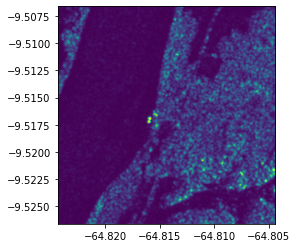

In [5]:
# Read geojson file

import fiona
import cv2
import rasterio
import geopandas as gpd

from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
from shapely.ops import transform

from rasterio.plot import show, reshape_as_image
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio.features import rasterize

evalscript = """
    //VERSION=3

    return [VV, 2 * VH, VV / VH / 100.0, dataMask]
"""

# return [VV, 2 * VH, VV / VH / 100.0, dataMask]
time_intervals = [('2021-02-19', '2021-02-24'), ('2021-03-25', '2021-03-27')]

coords = [[[-64.81439, -9.516611]]]

long_half_width = 0.01
lat_half_width = 0.01

geojson_file_name = 'aoi-1 copy 2.geojson'
geojson_file_path = os.path.join(dir_path, 'geojson/search-AOIs/' + geojson_file_name)

with fiona.open(geojson_file_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

for time_interval in time_intervals:
    for coord in coords[0]:
        print('x', coord[0])
        print('y', coord[1])

        # Create bounding box for Sentinel-1
        long_corner = coord[0]
        lat_corner = coord[1]
        bbox = BBox([long_corner-long_half_width, lat_corner-lat_half_width,
                     long_corner+long_half_width, lat_corner+lat_half_width], crs=CRS.WGS84)
        print('bbox', bbox)
        bbox_length = 500.0
        bbox_size = (bbox_length, bbox_length)

        request = SentinelHubRequest(
            evalscript=evalscript,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL1_IW_DES,
                    time_interval=time_interval,
                )
            ],
            responses=[
                SentinelHubRequest.output_response('default', MimeType.TIFF)
            ],
            bbox=bbox,
            size=bbox_size,
            config=config
        )

        image = request.get_data()[0]

        res = (long_half_width*2) / bbox_length
        transform = Affine.translation(coord[0] - long_half_width, coord[1] + lat_half_width) * Affine.scale(res, -res)

        time_interval_path = os.path.join(dir_path, '../data/' + time_interval[0] + '_' + time_interval[1])
        print('time_interval_path', time_interval_path)
        if not os.path.exists(time_interval_path):
            os.makedirs(time_interval_path)

        image_name = 'longlat' + str(long_corner) + '_' + str(lat_corner)
        image_path = os.path.join(time_interval_path, image_name + '.tiff')
        print('image_path', image_path)
    
        print('image', image)
        image = np.expand_dims(np.moveaxis(image.squeeze(), -1, 0)[0], axis=0)
        print(image.shape)
        with rasterio.open(
            image_path,
            'w',
            driver='GTiff',
            height=image.shape[1],
            width=image.shape[2],
            count=1,
            dtype=image.dtype,
            crs='+proj=latlong',
            transform=transform,
        ) as dst:
            dst.write(image)

        # Load the raster, mask it by the polygon and crop it
        with rasterio.open(image_path) as src:
            print('src', src)
            show(src)
            out_image, out_transform = mask(src, shapes, crop=True, nodata=0)

        out_meta = src.meta.copy()
        # Save the resulting raster  
        out_meta.update({"driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
        "transform": out_transform})

        masked_filename = os.path.join(time_interval_path, image_name + '_masked.tif')
        with rasterio.open(masked_filename, "w", **out_meta) as dest:
            dest.write(out_image)

In [16]:
import math

file_name = 'longlat-64.81439_-9.516611_masked'

folder1_name = '2021-03-25_2021-03-27'
folder2_name = '2021-02-19_2021-02-24'
img1_path = os.path.join(dir_path, '../data/' + folder1_name + '/' + file_name + '.tif')

diff_path = os.path.join(dir_path, '../data/diff')
diff_path = os.path.join(diff_path, folder1_name + '__' + folder2_name + '_' + file_name + '.png')
print('diff_path', diff_path)
# read image
img = cv2.imread(diff_path)
img = cv2.bitwise_not(img)

# convert to grayscale
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# apply Gaussian Blur
smoothed = cv2.GaussianBlur(gray, (0,0), sigmaX=8, sigmaY=8, borderType = cv2.BORDER_DEFAULT)

# do adaptive threshold on gray image
thresh = cv2.adaptiveThreshold(smoothed, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 65, 10)

# cv2.imshow("Threshold", thresh)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Set up the SimpleBlobdetector with default parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0
params.maxThreshold = 256

# Filter by Area.
params.filterByArea = True
params.minArea = 5
params.maxArea = 10000

# Filter by Color (black=0)
params.filterByColor = False
params.blobColor = 0

# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.5
params.maxCircularity = 1

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.5
params.maxConvexity = 1

# Filter by InertiaRatio
params.filterByInertia = False
params.minInertiaRatio = 0
params.maxInertiaRatio = 1

# Distance Between Blobs
params.minDistBetweenBlobs = 0

# Do detecting
detector = cv2.SimpleBlobDetector_create(params)

# Get keypoints
keypoints = detector.detect(thresh)

print(len(keypoints))
print('')

# Get keypoint locations and radius
for keypoint in keypoints:
    x = int(keypoint.pt[0])
    y = int(keypoint.pt[1])
    s = keypoint.size
    r = int(math.floor(s/2))
    print (x,y,r)
    #cv2.circle(img, (x, y), r, (0, 0, 255), 2)
    
# Convert x, y, r to long-lat
# Get long-lat of top left corner of image
# coords = [[[-64.81439, -9.516611]]]
long_corner = coords[0][0][0]
lat_corner = coords[0][0][1]

res = (long_half_width*2) / bbox_length
transform = Affine.translation(long_corner - long_half_width, lat_corner + lat_half_width) * Affine.scale(res, -res)
print(rasterio.transform.xy(transform, x, y))

# Draw blobs
blobs = cv2.drawKeypoints(thresh, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Save result
blob_path = os.path.join(dir_path, '../data/diff/' + folder1_name + '__' + folder2_name + '_' + file_name + '_blob.png')
print(blob_path)
cv2.imwrite(blob_path, blobs)

diff_path /Users/maggiewang/Dropbox/School/Harvard/senior_spring/cs288/amazon-barge-detection/data-collection/../data/diff/2021-03-25_2021-03-27__2021-02-19_2021-02-24_longlat-64.81439_-9.516611_masked.png
1

210 258 13
(-64.81405000000001, -9.515030999999999)
/Users/maggiewang/Dropbox/School/Harvard/senior_spring/cs288/amazon-barge-detection/data-collection/../data/diff/2021-03-25_2021-03-27__2021-02-19_2021-02-24_longlat-64.81439_-9.516611_masked_blob.png


True

/Users/maggiewang/Dropbox/School/Harvard/senior_spring/cs288/amazon-barge-detection/data-collection/../data/diff/2021-03-25_2021-03-27__2021-02-19_2021-02-24_longlat-64.81439_-9.516611_masked.png


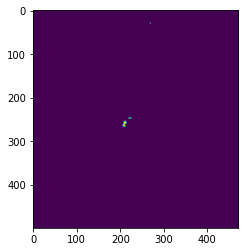

In [7]:
file_name = 'longlat-64.81439_-9.516611_masked'

folder1_name = '2021-03-25_2021-03-27'
folder2_name = '2021-02-19_2021-02-24'
img1_path = os.path.join(dir_path, '../data/' + folder1_name + '/' + file_name + '.tif')
img2_path = os.path.join(dir_path, '../data/' + folder2_name + '/' + file_name + '.tif')

im1_gray = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
im2_gray = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

(thresh1, im1_bw) = cv2.threshold(im1_gray, 200, 255, cv2.THRESH_BINARY) # | cv2.THRESH_OTSU)
(thresh2, im2_bw) = cv2.threshold(im2_gray, 200, 255, cv2.THRESH_BINARY) # | cv2.THRESH_OTSU)

sub = cv2.subtract(im1_bw, im2_bw)
# plt.figure()
# plt.imshow(im1_gray)
# plt.figure()
# plt.imshow(im2_gray)
plt.figure()
plt.imshow(sub)

diff_path = os.path.join(dir_path, '../data/diff')
if not os.path.exists(diff_path):
    os.makedirs(diff_path)

diff_path = os.path.join(diff_path, folder1_name + '__' + folder2_name + '_' + file_name + '.png')

print(diff_path)
cv2.imwrite(diff_path, sub)

# # Get contour of shapes

# ret, thresh = cv2.threshold(sub, 127, 255, 0)
# contours,hierarchy = cv2.findContours(thresh, 1, 2)
# cnt = contours[0]
# M = cv2.moments(cnt)
# print( M )

# Find blobs

# im = cv2.imread(diff_path)
# cv2.imshow('hi', sub)
im = cv2.GaussianBlur(sub, (0,0), sigmaX=9, sigmaY=9, borderType = cv2.BORDER_DEFAULT)

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10
params.maxThreshold = 200

# Filter by Area.
params.filterByArea = True
params.minArea = 1500

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

detector = cv2.SimpleBlobDetector(params)
# keypoints = detector.detect(im)
# im_with_keypoints = cv2.drawKeypoints(sub, keypoints, np.array([]), 
#                                       (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# # Show keypoints
# file_name = 'longlat-64.81439_-9.516611_blobs.tif'
# diff_path = os.path.join(diff_path, folder1_name + '__' + folder2_name + '_' + file_name)
# cv2.imwrite(im_with_keypoints, diff_path)